<a href="https://colab.research.google.com/github/Kaiziferr/XGBoost/blob/main/01_Learning_Curves_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
from unicodedata import normalize

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_val_score
)

from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

# **Config**
---


In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Resources extracted in Colombia'
random_seed=12354
warnings.filterwarnings("ignore")

# **Functions**
---

In [3]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word


def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

- The purpose of this notebook is to understand how to apply learning curves to detect underfitting or overfitting. For the purposes of the project, it will focus more on tuning and curves rather than on complex preprocessing.

- El propósito de este cuaderno es comprender cómo aplicar las curvas de aprendizaje para detectar el subajuste o el sobreajuste. Para los fines del proyecto, se centrará más en el ajuste y las curvas que en el preprocesamiento complejo.

# **Data**
---

In [4]:
url_master = 'https://drive.google.com/uc?id='
url_minero = 'https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero = url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


In [5]:
data_miner.columns = normalize_name_columns(data_miner.columns)

In [6]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [7]:
data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']] = data_miner[[
    'valor_contraprestacion',
    'cantidad_produccion']].astype('float64')
data_miner[
    'ano_produccion'] = data_miner[
    'ano_produccion'].astype('int64')

In [8]:
data_miner.isnull().sum()

,0
municipio_productor,0
departamento,0
recurso_natural,0
nombre_del_proyecto,0
ano_produccion,0
trimestre,0
unidad_medida,0
tipo_contraprestacion,0
valor_contraprestacion,0
cantidad_produccion,0


- There are no null values

- No hay valores nulos

- Information from the last six years will be taken
- Se tomará información de los últimos seis años.

In [9]:
data_miner = data_miner[
    (data_miner['ano_produccion']>2017)
    &
    (data_miner['ano_produccion'] < 2024)
]

In [10]:
data_miner['ano_produccion'].value_counts()

,count
ano_produccion,
2018,5305
2019,5133
2022,4150
2021,4141
2020,3965
2023,2355


In [11]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

- A first grouping is made with respect to the municipality, department, year of production, and quarter. To obtain the total value of the compensation, the number of transactions, and the amount of production.

- Se realiza una primera agrupación por municipio, departamento, año de producción y trimestre. Para obtener el valor total de la compensación, el número de transacciones y el monto de producción.

In [12]:
function_dictionary = {
    'valor_contraprestacion':['sum', 'count'],
    'cantidad_produccion': ['sum'],
}

data_transaction = data_miner.groupby([
    'municipio_productor',
    'departamento',
    'ano_produccion',
    'trimestre'
]).aggregate(
    function_dictionary
)

data_transaction.columns = [
    'valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion',
    'valor_cantidad_produccion_sum',
]

data_transaction.reset_index(inplace=True)
data_transaction

,municipio_productor,departamento,ano_produccion,trimestre,valor_contraprestacion_sum,n_transacciones_valor_contraprestacion,valor_cantidad_produccion_sum
0,Abejorral,Antioquia,2018,Trimestre 1,"2,783,489.00",1,"52,003.00"
1,Abejorral,Antioquia,2018,Trimestre 2,"3,659,452.00",1,"52,003.00"
2,Abejorral,Antioquia,2018,Trimestre 3,"5,732,763.00",1,"81,466.00"
3,Abejorral,Antioquia,2018,Trimestre 4,"11,706,438.00",2,"108,651.00"
4,Abejorral,Antioquia,2019,Trimestre 1,"5,793,131.00",2,"67,752.00"
...,...,...,...,...,...,...,...
9912,Zona Bananera,Magdalena,2020,Trimestre 4,"65,800.00",2,452.00
9913,Zona Bananera,Magdalena,2021,Trimestre 2,"76,600.00",2,526.00
9914,utica,Cundinamarca,2020,Trimestre 4,59.00,1,0.00
9915,utica,Cundinamarca,2021,Trimestre 4,77.00,1,0.00


- Then, a second grouping is performed by producing municipalities and departments to obtain the total and quarterly average of the compensation value; the number of transactions and its quarterly average; the production quantity value and the average production per quarter; as well as the number of quarters and years of activity

- Luego, se realiza una segunda agrupación por municipios y departamentos productores para obtener el promedio total y trimestral del valor de las compensaciones; el número de transacciones y su promedio trimestral; el valor de la cantidad de producción y la producción promedio por trimestre; así como el número de trimestres y años de actividad.

In [13]:
function_dictionary = {
    'valor_contraprestacion_sum':['sum', 'mean'],
    'n_transacciones_valor_contraprestacion': ['sum', 'mean'],
    'valor_cantidad_produccion_sum': ['sum', 'mean'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique'],
}


data_transaction_dos = data_transaction.groupby([
    'municipio_productor',
    'departamento',
]).aggregate(
    function_dictionary
)
data_transaction_dos.columns = [
    'valor_contraprestacion_sum',
    'valor_contraprestacion_mean',
    'n_transacciones_valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion_mean',
    'valor_cantidad_produccion_sum',
    'valor_cantidad_produccion_mean',
    'n_trimestre',
    'n_ano_produccion'
]

data_transaction_dos.reset_index(inplace=True)
data_transaction_dos

,municipio_productor,departamento,valor_contraprestacion_sum,valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,n_transacciones_valor_contraprestacion_mean,valor_cantidad_produccion_sum,valor_cantidad_produccion_mean,n_trimestre,n_ano_produccion
0,Abejorral,Antioquia,"54,668,833.00","4,555,736.08",18,1.50,"518,259.00","43,188.25",12,5
1,Abrego,Norte de Santander,"22,530,021.00","1,408,126.31",21,1.31,"111,626.00","6,976.62",16,5
2,Abriaqui,Antioquia,"357,383,964.00","21,022,586.12",45,2.65,"69,276.00","4,075.06",17,6
3,Acacias,Meta,"677,940,389.00","30,815,472.23",63,2.86,"3,092,471.00","140,566.86",22,6
4,Achi,Bolivar,"2,940,415,573.00","588,083,114.60",18,3.60,"361,520.00","72,304.00",5,2
...,...,...,...,...,...,...,...,...,...,...
705,Zaragoza,Antioquia,"34,398,813,794.00","1,563,582,445.18",101,4.59,"13,096,108.00","595,277.64",22,6
706,Zarzal,Valle del Cauca,"13,253,174.00","736,287.44",22,1.22,"84,672.00","4,704.00",18,6
707,Zipaquira,Cundinamarca,"3,429,252,068.00","163,297,717.52",61,2.90,"1,193,980.00","56,856.19",21,6
708,Zona Bananera,Magdalena,"2,280,457.00","380,076.17",16,2.67,"15,294.00","2,549.00",6,4


- Since there are similar municipalities in different departments, they are concatenate the features for create a new unique key

- Al existir municipios similares en diferentes departamentos, se concatenan las características para crear una nueva clave única

In [14]:
data_transaction_dos['id'] = data_transaction_dos.municipio_productor.str.cat(
    data_transaction_dos.departamento, sep='-'
)

data_transaction_dos = data_transaction_dos.drop(['municipio_productor', 'departamento'], axis=1)

In [15]:
data_transaction_dos = data_transaction_dos.iloc[:, ::-1]
data_transaction_dos.head(3)

,id,n_ano_produccion,n_trimestre,valor_cantidad_produccion_mean,valor_cantidad_produccion_sum,n_transacciones_valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,valor_contraprestacion_mean,valor_contraprestacion_sum
0,Abejorral-Antioquia,5,12,"43,188.25","518,259.00",1.50,18,"4,555,736.08","54,668,833.00"
1,Abrego-Norte de Santander,5,16,"6,976.62","111,626.00",1.31,21,"1,408,126.31","22,530,021.00"
2,Abriaqui-Antioquia,6,17,"4,075.06","69,276.00",2.65,45,"21,022,586.12","357,383,964.00"


# **Data Split**
---

- A split is generated to divide the training and validation data
- Se genera una división para dividir los datos de entrenamiento y validación.

In [16]:
X = data_transaction_dos.drop(['id','valor_contraprestacion_sum'], axis=1)
y = data_transaction_dos['valor_contraprestacion_sum']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_seed,
    test_size=0.25
)

# **Model**
---

- A XGBRegressor model is instantiated and tuned

- Se crea una instancia y se ajusta un modelo XGBRegressor

In [18]:
model = XGBRegressor(
    n_estimators = 1000,
    max_depth = 7,
    eta = 0.1,
    subsample = 0.7,
    colsample_bytree = 0.8
)

In [19]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

- Using the 10-fold CV technique, the error is calculated using the neg_mean_absolute_error metric

- Utilizando la técnica CV de 10 pliegues, el error se calcula utilizando la métrica neg_mean_absolute_error

In [24]:
cv = RepeatedKFold(
    n_splits = 10,
    n_repeats=3,
    random_state = random_seed
)

cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=12354)

In [25]:
scores = cross_val_score(
    model,
    X,
    y,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1
)

scores

array([-2.17185926e+09, -6.27788937e+08, -1.14029416e+10, -1.09912201e+11,
       -4.34797273e+08, -5.63480776e+10, -7.40320110e+09, -9.67353437e+10,
       -6.93165782e+08, -1.47329419e+09, -1.60466732e+10, -3.19799532e+09,
       -6.61856853e+08, -2.15234597e+09, -1.30827464e+11, -5.59294394e+09,
       -1.17426065e+10, -1.61954487e+09, -6.03288547e+10, -4.80191502e+09,
       -1.05993188e+11, -6.08399487e+10, -8.64208093e+09, -5.96028473e+09,
       -6.82597689e+10, -1.39549063e+09, -4.02263244e+09, -3.92295693e+09,
       -8.12785350e+09, -1.18432412e+10])

In [28]:
scores = np.absolute(scores)
scores

array([2.17185926e+09, 6.27788937e+08, 1.14029416e+10, 1.09912201e+11,
       4.34797273e+08, 5.63480776e+10, 7.40320110e+09, 9.67353437e+10,
       6.93165782e+08, 1.47329419e+09, 1.60466732e+10, 3.19799532e+09,
       6.61856853e+08, 2.15234597e+09, 1.30827464e+11, 5.59294394e+09,
       1.17426065e+10, 1.61954487e+09, 6.03288547e+10, 4.80191502e+09,
       1.05993188e+11, 6.08399487e+10, 8.64208093e+09, 5.96028473e+09,
       6.82597689e+10, 1.39549063e+09, 4.02263244e+09, 3.92295693e+09,
       8.12785350e+09, 1.18432412e+10])

In [27]:
print('Mean MAE: {:0,.0f}, Std: {:0,.0f}'.format(scores.mean(), scores.std()))

Mean MAE: 26,772,743,898, Std: 38,501,714,784


- The error is 27,398,178,371 and it is above the 75th percentile.
- El error es 27.398.178.371 y está por encima del percentil 75.

In [29]:
y.describe()

,valor_contraprestacion_sum
count,710.00
mean,"29,244,575,006.88"
std,"371,166,053,278.03"
min,77.00
25%,"7,931,449.75"
50%,"63,407,247.50"
75%,"1,062,162,433.75"
max,"8,939,234,565,659.00"


- Another XGBRegressor model is instantiated with the mean_absolute_error metric
- Se crea una instancia de otro modelo XGBRegressor con la métrica mean_absolute_error

In [30]:
model = XGBRegressor(
    n_estimators = 200,
    max_depth = 7,
    eta = 0.05,
    subsample = 1,
    colsample_bytree=1,
    eval_metric=mean_absolute_error
)

In [31]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.05,
             eval_metric=<function mean_absolute_error at 0x7a33a8dd42c0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

- The lists containing the training and validation error metrics are accessed in each iteration.

- Se accede a las listas que contienen las métricas de errores de entrenamiento y validación en cada iteración.

In [32]:
results = model.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

- In this graph, it is evident that the model has convergence at tree 175 with the configuration hyperparameters in the second instance of the model.

- En este gráfico se evidencia que el modelo tiene convergencia en el árbol 175 con los hiperparámetros de configuración en la segunda instancia del modelo.

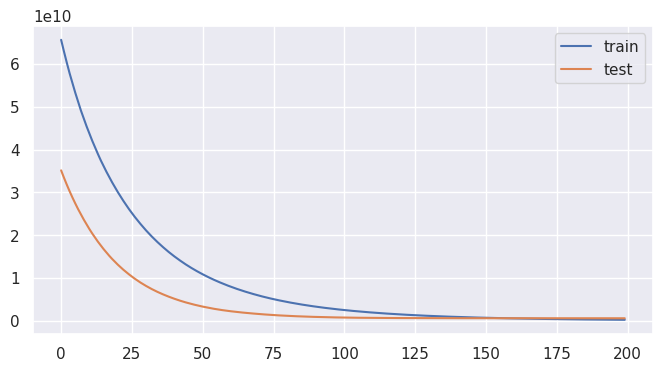

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results['validation_0']['mean_absolute_error'], label='train')
ax.plot(results['validation_1']['mean_absolute_error'], label='test')
plt.legend()
plt.show()

In [34]:
model = XGBRegressor(
    n_estimators = 175,
    max_depth = 7,
    eta = 0.05,
    subsample = 1,
    colsample_bytree=1,
    eval_metric=mean_absolute_error
)

In [35]:
model.fit(X_train, y_train, verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.05,
             eval_metric=<function mean_absolute_error at 0x7a33a8dd42c0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=175,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
y_predict = model.predict(X_test)

In [37]:
error = mean_absolute_error(y_test, y_predict)

In [38]:
print('Mean MAE: {:0,.2f}'.format(error))

Mean MAE: 599,759,110.80


- The model performs better with the modification of the hyperparameters, thanks to the interpretation of the loss curves.

- El modelo funciona mejor con la modificación de los hiperparámetros, gracias a la interpretación de las curvas de pérdida.

In [39]:
model.objective

'reg:squarederror'

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr